In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
from twelvedata import TDClient

In [ ]:
# --- Configuration ---
API_KEY = ''   # ← replace with your Twelve Data API key
OUTPUT_DIR = "./data"        # directory where CSVs will go
SYMBOLS   = ["EUR/USD", "XAU/USD"]
INTERVALS = ["1min", "5min", "15min", "30min", "1h"]
DAYS      = 90                   # how many days of data back (≈2 months)

# --- Create client ---
td = TDClient(apikey=API_KEY)

# --- Ensure output directory exists ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Date ranges ---
end_date   = datetime.utcnow()
start_date = end_date - timedelta(days=DAYS)

start_str  = start_date.strftime("%Y-%m-%d %H:%M:%S")
end_str    = end_date.strftime("%Y-%m-%d %H:%M:%S")

print(f"Requesting data from {start_str} to {end_str}")

# --- Download loop ---
for symbol in SYMBOLS:
    for interval in INTERVALS:
        print(f"Downloading {symbol} @ interval {interval}")
        try:
            ts = td.time_series(
                symbol     = symbol,
                interval   = interval,
                start_date = start_str,
                end_date   = end_str,
                timezone   = "UTC",
                outputsize = 5000   # high number, will truncate by date anyway
            )
            df = ts.as_pandas()
            
            # Clean up / make sure datetime index
            if "datetime" in df.columns:
                df.set_index("datetime", inplace=True)
            
            # Save to CSV
            fname = f"{symbol.replace('/','')}_{interval}.csv"
            path  = os.path.join(OUTPUT_DIR, fname)
            df.to_csv(path)
            print(f"Saved to {path}, rows = {len(df)}")
            
        except Exception as e:
            print(f"ERROR for {symbol} @ {interval} → {e}")

print("Done.")

Requesting data from 2025-08-03 00:50:56 to 2025-11-01 00:50:56
Saved to ./data/EURUSD_1min.csv, rows = 5000
Saved to ./data/EURUSD_5min.csv, rows = 5000
Saved to ./data/EURUSD_15min.csv, rows = 5000
Saved to ./data/EURUSD_30min.csv, rows = 3112
Saved to ./data/EURUSD_1h.csv, rows = 1560
Saved to ./data/XAUUSD_1min.csv, rows = 5000
Saved to ./data/XAUUSD_5min.csv, rows = 5000
Saved to ./data/XAUUSD_15min.csv, rows = 5000
Saved to ./data/XAUUSD_30min.csv, rows = 3517
Saved to ./data/XAUUSD_1h.csv, rows = 1765
Done.


Matplotlib created a temporary cache directory at /tmp/matplotlib-h84s3qif because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


                       open    high     low   close
datetime                                           
2025-10-31 21:42:00  1.1535  1.1535  1.1535  1.1535
2025-10-31 21:40:00  1.1535  1.1535  1.1535  1.1535
2025-10-31 21:39:00  1.1535  1.1535  1.1535  1.1535
2025-10-31 21:37:00  1.1535  1.1535  1.1535  1.1535
2025-10-31 21:35:00  1.1535  1.1535  1.1535  1.1535


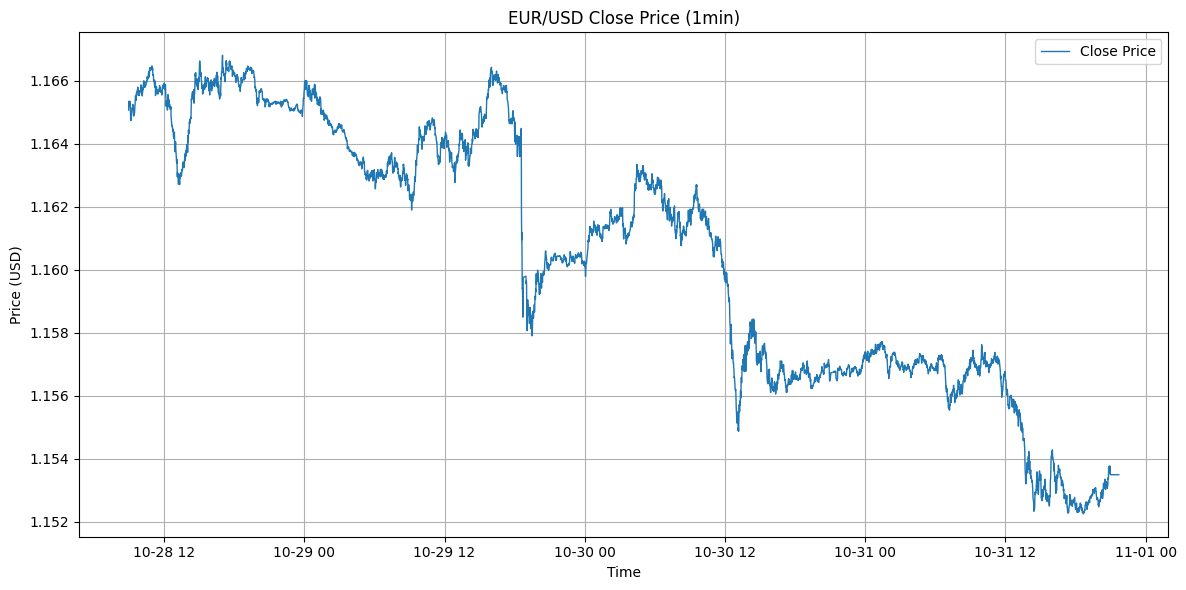

In [5]:
import matplotlib.pyplot as plt
# --- Load the CSV file ---
# Replace with your filename, e.g. "data_tw12/EURUSD_1min.csv"
file_path = "data/EURUSD_1min.csv"

# Try to automatically detect date column
df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# If the index isn't datetime, convert manually
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

print(df.head())

# --- Plot the Close price ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Close Price", linewidth=1)
plt.title("EUR/USD Close Price (1min)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
from twelvedata import TDClient
import pandas as pd
import os
from datetime import datetime, timedelta

# --- Configuration ---
API_KEY   = "4d033e66929c426c9f21887e4206b5b2"
SYMBOLS   = ["EUR/USD", "XAU/USD"]
INTERVALS = ["1min", "5min", "15min", "30min", "1h"]
CHUNKS    = 5          # number of batches
POINTS    = 5000       # points per batch
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

td = TDClient(apikey=API_KEY)

# --- Helper to get one chunk ---
def fetch_chunk(symbol, interval, end_date):
    ts = td.time_series(
        symbol     = symbol,
        interval   = interval,
        end_date   = end_date,
        outputsize = POINTS,
        timezone   = "UTC"
    )
    df = ts.as_pandas()
    df = df.sort_index()   # ensure ascending order
    return df

# --- Main loop ---
for symbol in SYMBOLS:
    for interval in INTERVALS:
        print(f"Downloading {symbol} @ {interval}")
        all_data = []
        end_time = datetime.utcnow()  # start from now

        for i in range(CHUNKS):
            print(f"  Chunk {i+1}/{CHUNKS}, ending at {end_time}")
            try:
                df = fetch_chunk(symbol, interval, end_time.strftime("%Y-%m-%d %H:%M:%S"))
                if df.empty:
                    print("  Empty chunk, stopping.")
                    break

                all_data.append(df)

                # next end date = earliest timestamp minus 1 interval
                new_end = df.index.min() - timedelta(minutes=1)
                end_time = new_end
            except Exception as e:
                print(f"  Error in chunk {i+1}: {e}")
                break

        if all_data:
            df_full = pd.concat(all_data).sort_index()
            fname = f"{symbol.replace('/','')}_{interval}_paged.csv"
            path  = os.path.join(OUTPUT_DIR, fname)
            df_full.to_csv(path)
            print(f"Saved {len(df_full)} rows to {path}")
        else:
            print(f"No data collected for {symbol} @ {interval}")


  Chunk 1/5, ending at 2025-11-01 01:12:13.141006
  Chunk 2/5, ending at 2025-10-28 08:57:00
  Chunk 3/5, ending at 2025-10-22 19:54:00
  Chunk 4/5, ending at 2025-10-17 06:50:00
  Chunk 5/5, ending at 2025-10-13 18:01:00
Saved 25000 rows to data/EURUSD_1min_paged.csv
  Chunk 1/5, ending at 2025-11-01 01:12:19.092519
  Chunk 2/5, ending at 2025-10-08 09:39:00
  Chunk 3/5, ending at 2025-09-12 19:54:00
  Chunk 4/5, ending at 2025-08-20 07:39:00
  Error in chunk 4: You have run out of API credits for the current minute. 9 API credits were used, with the current limit being 8. Wait for the next minute or consider switching to a higher tier plan at https://twelvedata.com/pricing
Saved 15000 rows to data/EURUSD_5min_paged.csv
  Chunk 1/5, ending at 2025-11-01 01:12:26.136835
  Error in chunk 1: You have run out of API credits for the current minute. 10 API credits were used, with the current limit being 8. Wait for the next minute or consider switching to a higher tier plan at https://twelv

In [3]:
import os
import time
from datetime import datetime, timedelta
import pandas as pd
from twelvedata import TDClient

# --- CONFIG ---
API_KEY = "4d033e66929c426c9f21887e4206b5b2"
SYMBOLS   = ["EUR/USD", "XAU/USD"]
INTERVALS = ["1min", "5min", "15min", "30min", "1h"]
CHUNKS_PER_SYMBOL = 50       # number of 5000-point chunks per symbol/interval
POINTS_PER_CHUNK  = 5000
MAX_CHUNKS_PER_MINUTE = 5
WAIT_TIME_BETWEEN_BATCHES = 90     # seconds
MAX_CHUNKS_PER_DAY = 500
OUTPUT_DIR = "data"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- INIT CLIENT ---
td = TDClient(apikey=API_KEY)

# --- TRACKERS ---
total_chunks_fetched = 0
chunk_counter_in_minute = 0

# --- HELPER FUNCTION ---
def fetch_chunk(symbol, interval, end_date):
    ts = td.time_series(
        symbol     = symbol,
        interval   = interval,
        end_date   = end_date,
        outputsize = POINTS_PER_CHUNK,
        timezone   = "UTC"
    )
    df = ts.as_pandas()
    df = df.sort_index()  # ascending time order
    return df

# --- MAIN LOOP ---
for symbol in SYMBOLS:
    for interval in INTERVALS:
        print(f"\n=== Downloading {symbol} @ {interval} ===")
        all_data = []
        end_time = datetime.utcnow()

        for i in range(CHUNKS_PER_SYMBOL):
            # --- Check daily quota ---
            if total_chunks_fetched >= MAX_CHUNKS_PER_DAY:
                print("🚫 Daily chunk limit (500) reached. Stopping.")
                break

            # --- Check per-minute quota ---
            if chunk_counter_in_minute >= MAX_CHUNKS_PER_MINUTE:
                print(f"🕒 Reached {MAX_CHUNKS_PER_MINUTE} chunks, waiting {WAIT_TIME_BETWEEN_BATCHES} s...")
                time.sleep(WAIT_TIME_BETWEEN_BATCHES)
                chunk_counter_in_minute = 0

            print(f"  Fetching chunk {i+1}/{CHUNKS_PER_SYMBOL}, end={end_time}")

            try:
                df = fetch_chunk(symbol, interval, end_time.strftime("%Y-%m-%d %H:%M:%S"))
                if df.empty:
                    print("  Empty response — stopping further chunks.")
                    break

                all_data.append(df)

                # Prepare next chunk
                end_time = df.index.min() - timedelta(minutes=1)
                total_chunks_fetched += 1
                chunk_counter_in_minute += 1

            except Exception as e:
                print(f"  ⚠️ Error: {e}")
                time.sleep(5)  # brief pause before retry/next
                continue

        # --- Save combined data ---
        if all_data:
            df_full = pd.concat(all_data).sort_index()
            fname = f"{symbol.replace('/','')}_{interval}_paged.csv"
            path  = os.path.join(OUTPUT_DIR, fname)
            df_full.to_csv(path)
            print(f"✅ Saved {len(df_full)} rows → {path}")
        else:
            print(f"⚠️ No data collected for {symbol} @ {interval}")

print(f"\nDone! Total chunks fetched: {total_chunks_fetched}")



=== Downloading EUR/USD @ 1min ===
  Fetching chunk 1/50, end=2025-11-01 01:17:46.854690
  Fetching chunk 2/50, end=2025-10-28 08:57:00
  Fetching chunk 3/50, end=2025-10-22 19:54:00
  Fetching chunk 4/50, end=2025-10-17 06:50:00
  Fetching chunk 5/50, end=2025-10-13 18:01:00
🕒 Reached 5 chunks, waiting 90 s...
  Fetching chunk 6/50, end=2025-10-08 04:18:00
  Fetching chunk 7/50, end=2025-10-02 14:47:00
  Fetching chunk 8/50, end=2025-09-29 01:51:00
  Fetching chunk 9/50, end=2025-09-23 11:39:00
  Fetching chunk 10/50, end=2025-09-17 21:43:00
🕒 Reached 5 chunks, waiting 90 s...
  Fetching chunk 11/50, end=2025-09-12 07:26:00
  Fetching chunk 12/50, end=2025-09-08 19:05:00
  Fetching chunk 13/50, end=2025-09-03 04:18:00
  Fetching chunk 14/50, end=2025-08-28 12:36:00
  Fetching chunk 15/50, end=2025-08-24 23:37:00
🕒 Reached 5 chunks, waiting 90 s...
  Fetching chunk 16/50, end=2025-08-19 08:27:00
  Fetching chunk 17/50, end=2025-08-13 16:13:00
  Fetching chunk 18/50, end=2025-08-08 00:

                        open     high      low    close
datetime                                               
2025-11-01 00:45:00  4001.03  4003.26  4001.02  4003.26
2025-11-01 00:30:00  4001.27  4003.76  4001.02  4001.02
2025-11-01 00:15:00  4002.58  4005.63  4001.26  4001.27
2025-11-01 00:00:00  4000.16  4003.62  3995.51  4002.59
2025-10-31 23:45:00  4003.13  4003.52  4000.16  4000.16


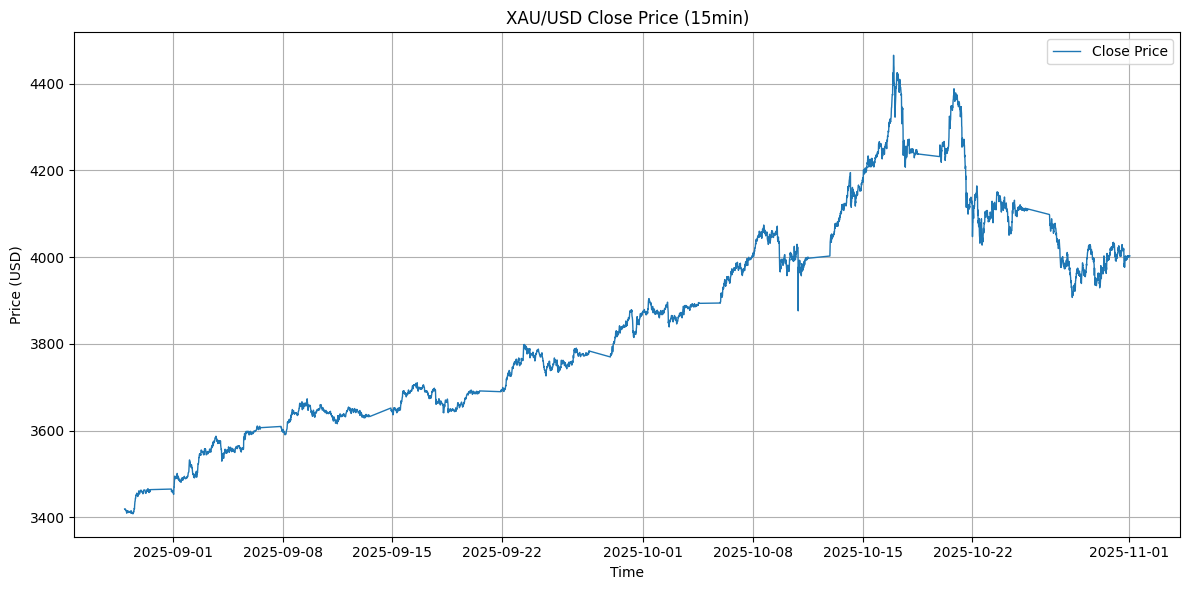

In [8]:
# --- Load the CSV file ---
# Replace with your filename, e.g. "data_tw12/EURUSD_1min.csv"
file_path = "data/XAUUSD_15min.csv"

# Try to automatically detect date column
df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# If the index isn't datetime, convert manually
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

print(df.head())

# --- Plot the Close price ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Close Price", linewidth=1)
plt.title("XAU/USD Close Price (15min)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                           open        high         low       close
datetime                                                           
2020-01-24 02:00:00  1561.96997  1562.50000  1561.93005  1562.07544
2020-01-24 02:15:00  1562.06995  1562.14221  1561.32996  1561.59998
2020-01-24 02:30:00  1561.58557  1561.76001  1561.24841  1561.38501
2020-01-24 02:45:00  1561.37000  1561.85999  1561.23999  1561.75000
2020-01-24 03:00:00  1561.80005  1561.89001  1561.46997  1561.59229


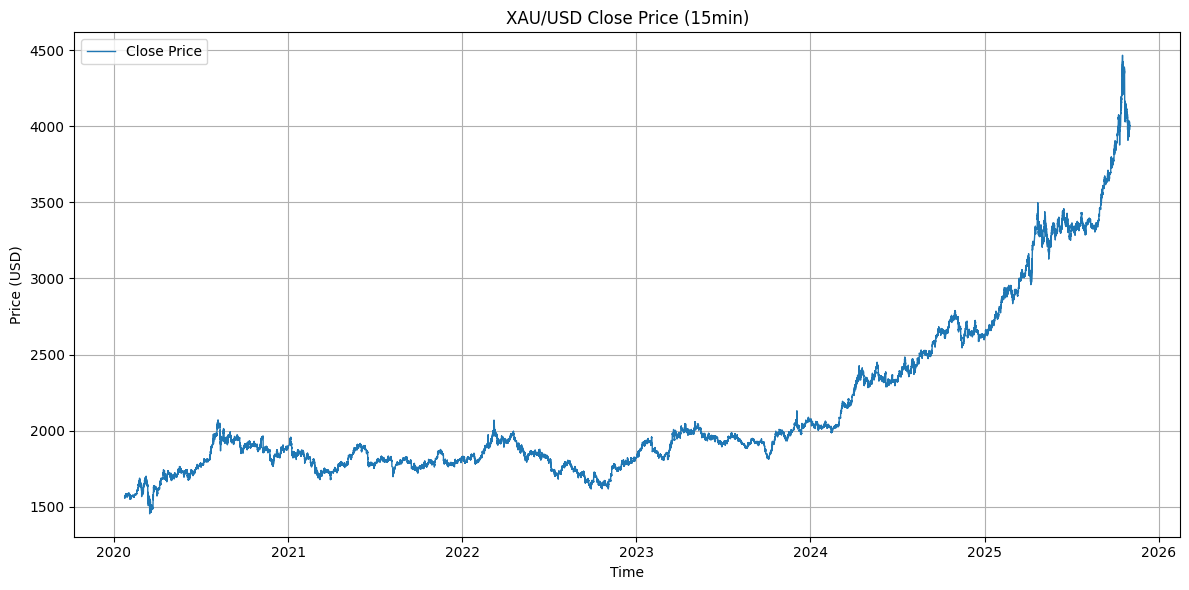

In [7]:
# --- Load the CSV file ---
# Replace with your filename, e.g. "data_tw12/EURUSD_1min.csv"
file_path = "data/XAUUSD_15min_paged.csv"

# Try to automatically detect date column
df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# If the index isn't datetime, convert manually
if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

print(df.head())

# --- Plot the Close price ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Close Price", linewidth=1)
plt.title("XAU/USD Close Price (15min)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()